In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generative model

In [3]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.001)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

In [4]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Inference network

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
    
    def embed(self, x):
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        rhoA = self.embed(A['x'])
        rhoB = self.embed(B['x'])
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [6]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = max_epochs)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    pk = SimulatorBlob(Npix = NPIX).sample(conditions = dict(theta = np.array([4.])))['pk_fn']
    prior = sim.powersampler.get_prior_Q_factors(pk)
    prior = (prior[0], prior[1].cuda(), prior[2])
    x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
    
    draws = net.lre.get_noise_samples_GEDA(n_draws, prior, steps = 300, reset = True, gamma = GAMMA)
    
    bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    return bounds

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1820.56it/s]
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/cweniger/.pyenv/versions/3.10.11/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  88%|███████ | 15/17 [00:00<00:00, 15.21it/s, loss=-2.16e+03, v_num=59]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|███████▌| 16/17 [00:01<00:00, 15.61it/s, loss=-2.16e+03, v_num=59]
Epoch 0: 100%|█| 17/17 [00:01<00:00, 16.06it/s, loss=-2.16e+03, v_num=59, val_lo
Epoch 1:  88%|▉| 15/17 [00:00<00:00, 18.45it/s, loss=-3.76e+03, v_num=59, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  94%|▉| 16/17 [00:00<00:00, 18.41it/s, loss=-3.76e+03, v_num=59, val_lo
Epoch 1: 100%|█| 17/17 [00:00<00:00, 18.97it/s, loss=-3.76e+03, v_num=59, val_lo
Epoch 2:  88%|▉| 15/17 [00:00<00:00, 15.04it/s, loss=-4.48e+03, v_num=59, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  94%|▉| 16/17 [00:01<00:00, 15.12it/s, loss=-4.48e+03, v_num=59, val_lo
Epoch 2: 100%|█| 17/17 [00:01<00:00, 15.38it/s, loss=-4.48e+03, v_num=59, val_lo
Epoch 3:  88%|▉|

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 17/17 [00:01<00:00, 15.31it/s, loss=-6.89e+03, v_num=59, val_l


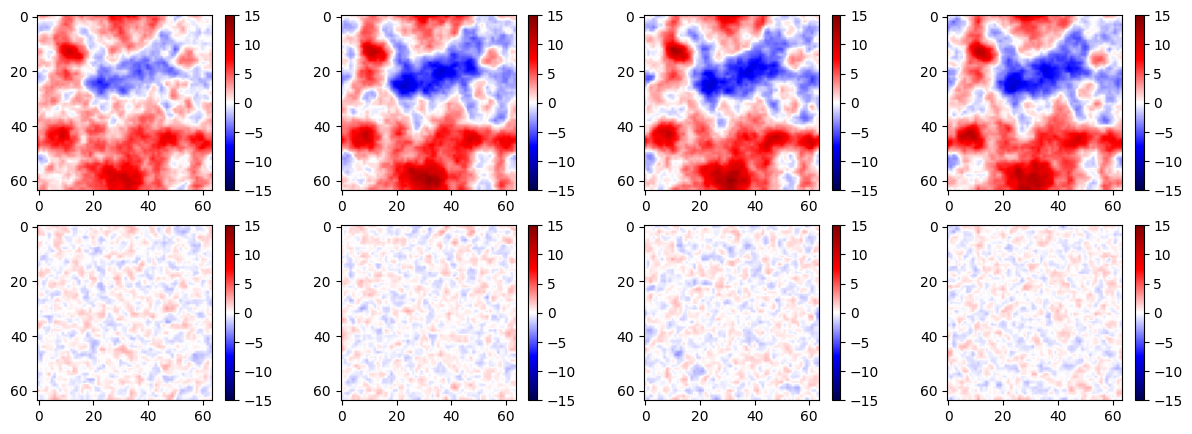

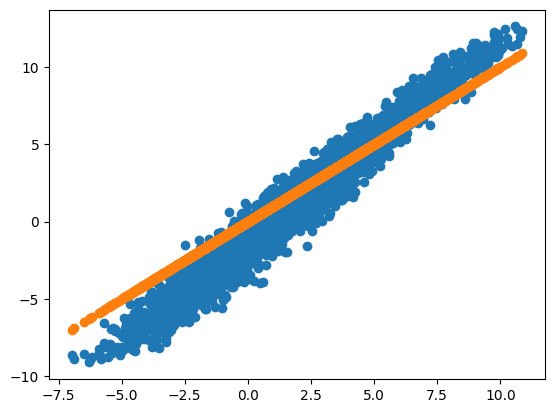

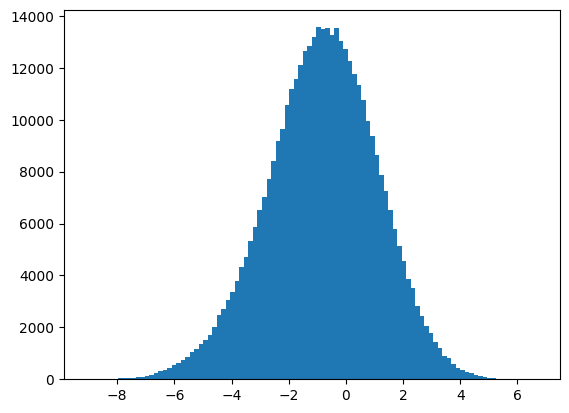

Residual percentiles: [-4.8022438  -2.72103232 -0.77542108  1.07115918  2.77572727]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1524.01it/s]


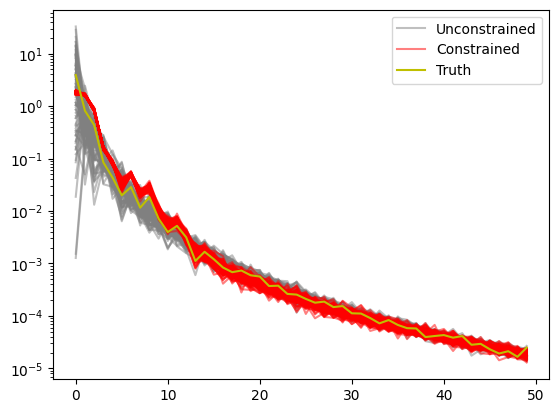

In [7]:
bounds = None
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 100, gamma = 1e-1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3297.12it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████▍ | 15/17 [00:01<00:00, 14.73it/s, loss=-227, v_num=61]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|████████████▏| 16/17 [00:01<00:00, 14.79it/s, loss=-227, v_num=61]
Epoch 0: 100%|█| 17/17 [00:01<00:00, 15.26it/s, loss=-227, v_num=61, val_loss=-3
Epoch 1:  88%|▉| 15/17 [00:00<00:00, 15.56it/s, loss=-2.66e+03, v_num=61, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  94%|▉| 16/17 [00:01<00:00, 15.69it/s, loss=-2.66e+03, v_num=61, val_lo
Epoch 1: 100%|█| 17/17 [00:01<00:00, 16.04it/s, loss=-2.66e+03, v_num=61, val_lo
Epoch 2:  88%|▉| 15/17 [00:01<00:00, 14.71it/s, loss=-3.09e+03, v_num=61, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  94%|▉| 16/17 [00:01<00:00, 14.84it/s, loss=-3.09e+03, v_num=61, val_lo
Epoch 2: 100%|█| 17/17 [00:01<00:00, 15.31it/s, loss=-3.09e+03, v_num=61, val_lo
Epoch 3:  88%|▉|

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 17/17 [00:01<00:00, 15.18it/s, loss=-3.63e+03, v_num=61, val_l


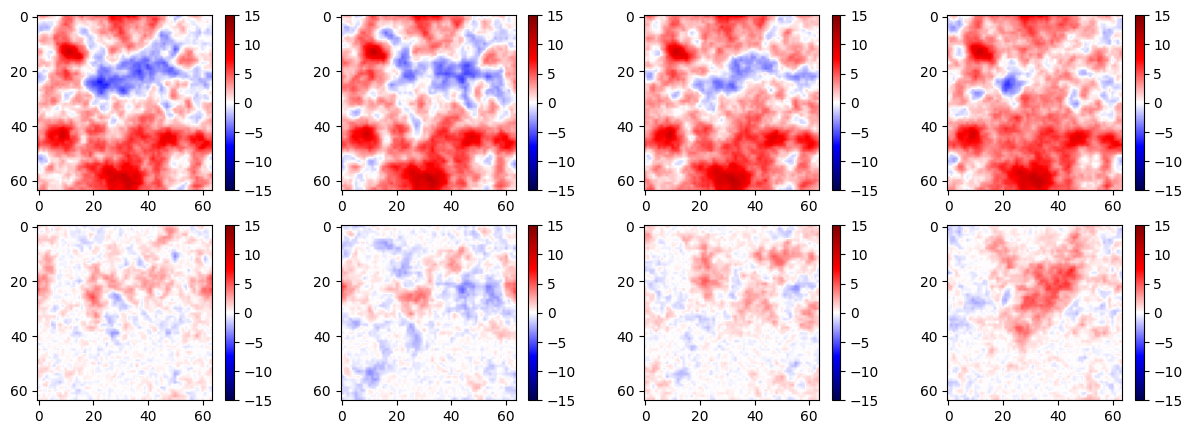

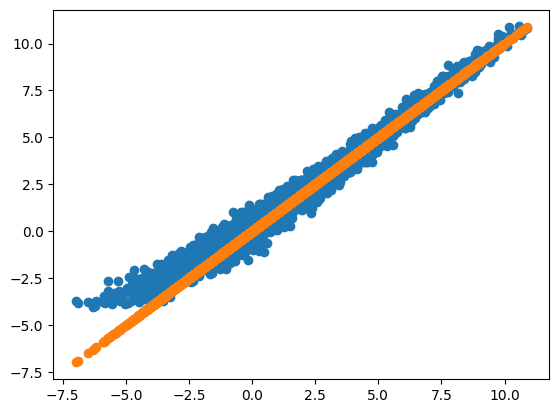

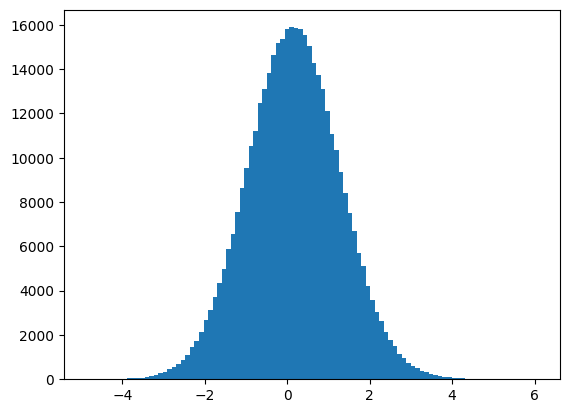

Residual percentiles: [-2.03888969 -0.95914899  0.15094982  1.27030862  2.38803011]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1779.55it/s]


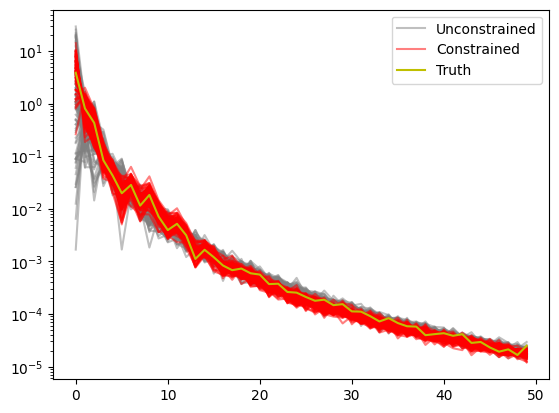

In [8]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 100, gamma = 1e-1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3361.75it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████▉ | 15/17 [00:01<00:00, 14.78it/s, loss=3.15e+03, v_num=62]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|████████▍| 16/17 [00:01<00:00, 14.99it/s, loss=3.15e+03, v_num=62]
Epoch 0: 100%|█| 17/17 [00:01<00:00, 15.34it/s, loss=3.15e+03, v_num=62, val_los
Epoch 1:  88%|▉| 15/17 [00:01<00:00, 14.84it/s, loss=-2.83e+03, v_num=62, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  94%|▉| 16/17 [00:01<00:00, 14.94it/s, loss=-2.83e+03, v_num=62, val_lo
Epoch 1: 100%|█| 17/17 [00:01<00:00, 15.28it/s, loss=-2.83e+03, v_num=62, val_lo
Epoch 2:  88%|▉| 15/17 [00:01<00:00, 13.93it/s, loss=-3.64e+03, v_num=62, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  94%|▉| 16/17 [00:01<00:00, 14.13it/s, loss=-3.64e+03, v_num=62, val_lo
Epoch 2: 100%|█| 17/17 [00:01<00:00, 14.46it/s, loss=-3.64e+03, v_num=62, val_lo
Epoch 3:  88%|▉|

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 17/17 [00:01<00:00, 14.63it/s, loss=-4.68e+03, v_num=62, val_l


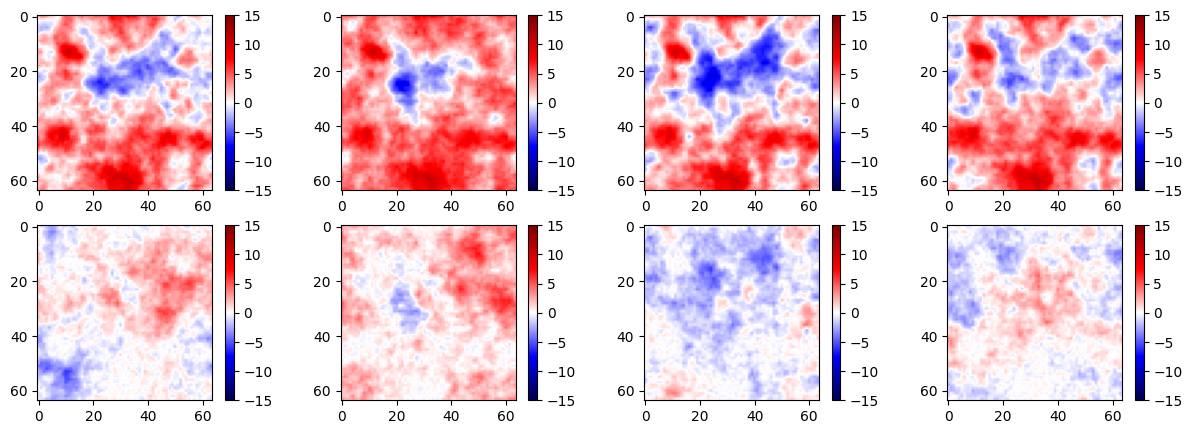

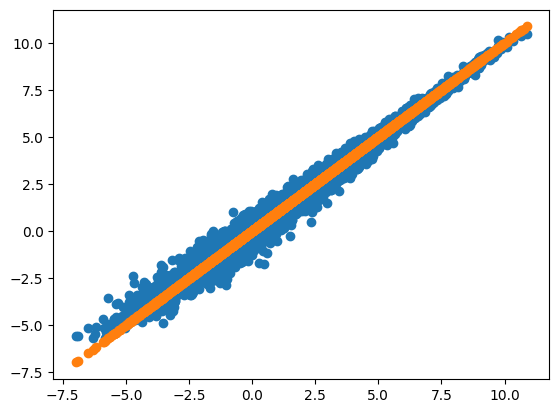

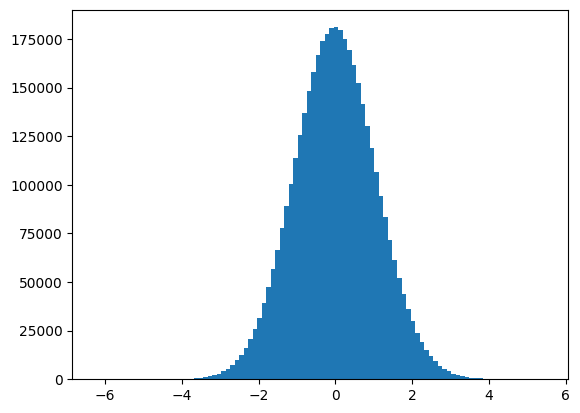

Residual percentiles: [-2.0737023  -1.05669498 -0.00739492  1.05141572  2.09168658]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2083.10it/s]


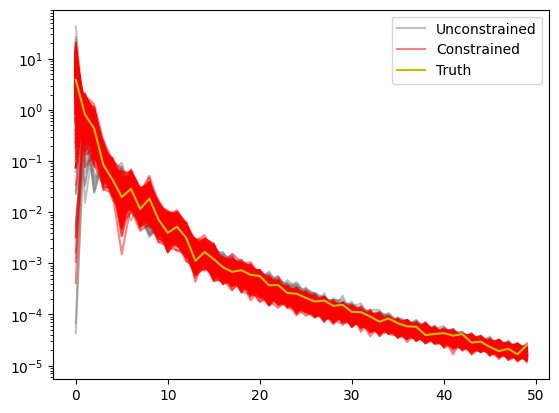

In [9]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 1000, gamma = 1e-1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3275.70it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|████████▊ | 15/17 [00:00<00:00, 15.25it/s, loss=2.4e+04, v_num=64]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|█████████▍| 16/17 [00:01<00:00, 15.51it/s, loss=2.4e+04, v_num=64]
Epoch 0: 100%|█| 17/17 [00:01<00:00, 15.96it/s, loss=2.4e+04, v_num=64, val_loss
Epoch 1:  88%|▉| 15/17 [00:00<00:00, 15.49it/s, loss=1.6e+03, v_num=64, val_loss
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 1:  94%|▉| 16/17 [00:01<00:00, 15.70it/s, loss=1.6e+03, v_num=64, val_loss
Epoch 1: 100%|█| 17/17 [00:01<00:00, 16.05it/s, loss=1.6e+03, v_num=64, val_loss
Epoch 2:  88%|▉| 15/17 [00:00<00:00, 15.80it/s, loss=-2.63e+03, v_num=64, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/2 [00:00<?, ?it/s]
Epoch 2:  94%|▉| 16/17 [00:00<00:00, 16.01it/s, loss=-2.63e+03, v_num=64, val_lo
Epoch 2: 100%|█| 17/17 [00:01<00:00, 16.32it/s, loss=-2.63e+03, v_num=64, val_lo
Epoch 3:  88%|▉|

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 17/17 [00:01<00:00, 14.08it/s, loss=-4.96e+03, v_num=64, val_l


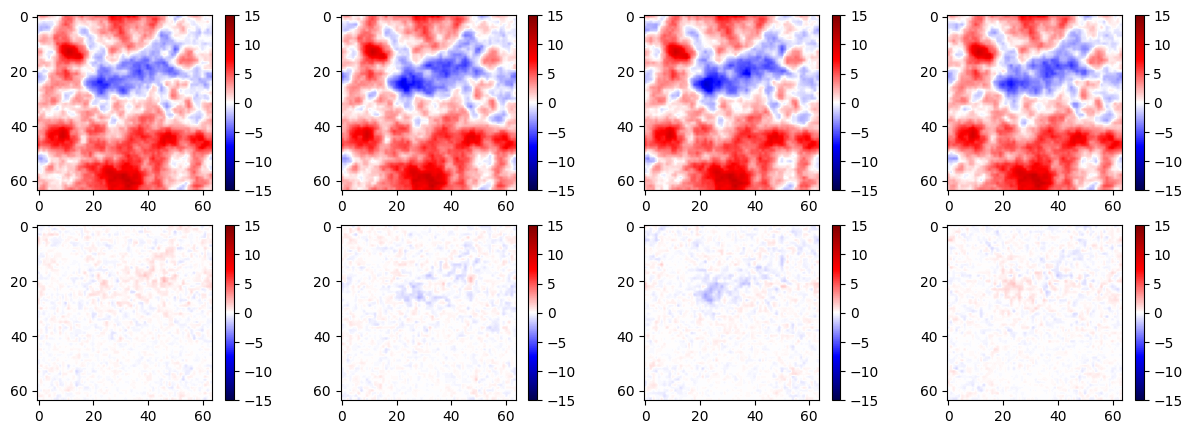

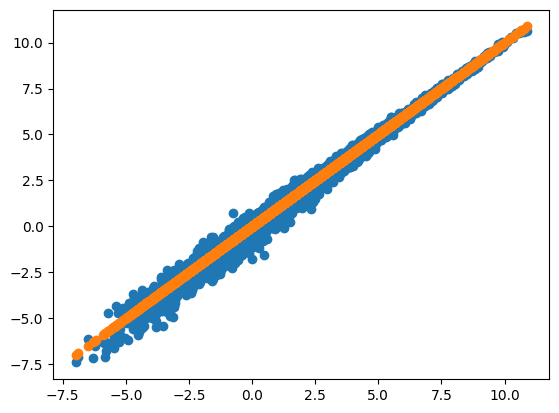

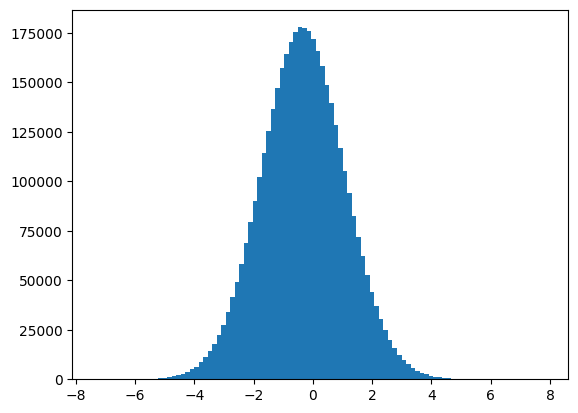

Residual percentiles: [-3.07347379 -1.71904402 -0.33272053  1.06516393  2.44098308]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2078.48it/s]


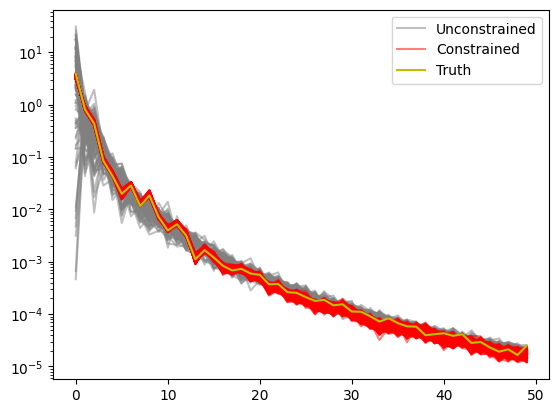

In [10]:
bounds = round(bounds = bounds, max_epochs = 15, n_draws = 1000, gamma = 1)